In [ ]:
# Problem Statement

# End to End ARIMA forecasting model is being explained, please pick up the following stocks and generate forecasts
# accordingly

# Stocks:

#1. NASDAQ.AAPL
#2. NASDAQ.ADP
#3. NASDAQ.CBOE
#4. NASDAQ.CSCO
#5. NASDAQ.EBAY

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import datetime
import sys
import seaborn as sns
import statsmodels
import time
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from scipy.stats.mstats import normaltest

from matplotlib.pyplot import acorr
plt.style.use('fivethirtyeight')
%matplotlib inline

In [167]:
df = pd.read_csv('data_stocks.csv')

In [168]:
df.shape

(41266, 502)

In [144]:
df.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [171]:
df['DATE_F'] = df.DATE.apply(lambda x:time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

In [172]:
df['logsp500']= np.log(df['SP500'])
df['diflogsp500'] = df['logsp500'] - df['logsp500'].shift(periods=-1)
df = df.dropna()

In [173]:
df.shape

(41264, 505)

In [152]:
df.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS,DATE_F,logsp500,diflogsp500
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,39.88,82.03,7.36,50.22,63.86,122.000,53.350,2017-04-03 19:00:00,7.767945,-0.000207
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,39.88,82.03,7.38,50.22,63.74,121.770,53.350,2017-04-03 19:01:00,7.768153,0.000601
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,39.98,82.02,7.36,50.12,63.75,121.700,53.365,2017-04-03 19:02:00,7.767552,-0.000690
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,39.99,82.02,7.35,50.16,63.88,121.700,53.380,2017-04-03 19:03:00,7.768242,-0.000228
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,39.96,82.03,7.36,50.20,63.91,121.695,53.240,2017-04-03 19:04:00,7.768470,-0.000326


In [174]:
data = df[['DATE','DATE_F','SP500','logsp500','diflogsp500']][:-100]
test = df[['DATE','DATE_F','SP500','logsp500','diflogsp500']][-100:]

In [177]:
data.shape

(41164, 5)

In [176]:
data.head()

,DATE,DATE_F,SP500,logsp500,diflogsp500
0,1491226200,2017-04-03 19:00:00,2363.6101,7.767945,-0.000207
1,1491226260,2017-04-03 19:01:00,2364.1001,7.768153,0.000601
2,1491226320,2017-04-03 19:02:00,2362.6799,7.767552,-0.000690
3,1491226380,2017-04-03 19:03:00,2364.3101,7.768242,-0.000228
4,1491226440,2017-04-03 19:04:00,2364.8501,7.768470,-0.000326


In [ ]:
?plt.title

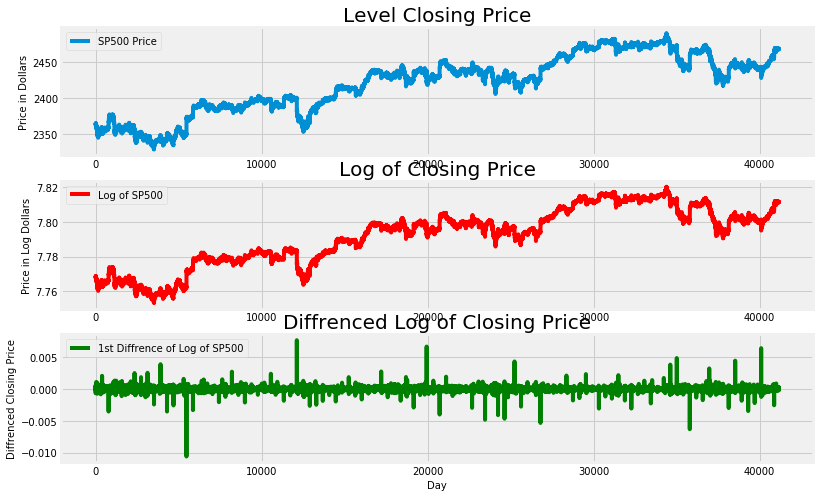

In [157]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(data.SP500, label = "SP500 Price")
plt.title("Level Closing Price", size = 20,)
plt.ylabel("Price in Dollars", size = 10)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data.logsp500, label = 'Log of SP500', color = 'r')
plt.title("Log of Closing Price", size = 20,)
plt.ylabel("Price in Log Dollars", size = 10)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot( data.diflogsp500, label = '1st Diffrence of Log of SP500', color = 'g')
plt.title("Diffrenced Log of Closing Price", size = 20,)
plt.ylabel("Diffrenced Closing Price", size = 10)
plt.xlabel('Day', size = 10)
plt.legend()

Text(0,0.5,'PACF')

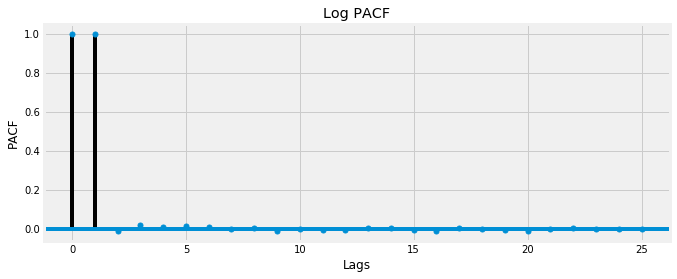

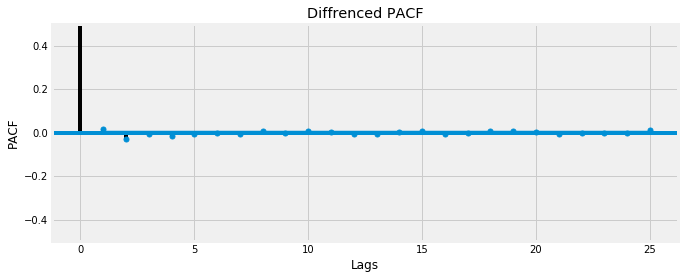

In [94]:
fig, ax = plt.subplots(figsize=(10,4))

plot_pacf(data.logsp500, lags = 25, ax = ax)
ax.set_title('Log PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(10,4))

plot_pacf(data.diflogsp500, lags = 25, ax = ax)
ax.set_title('Diffrenced PACF')
ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

Text(0,0.5,'PACF')

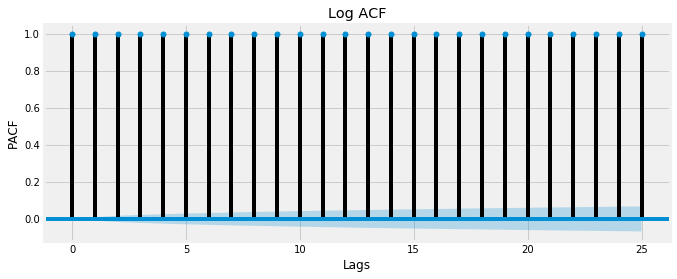

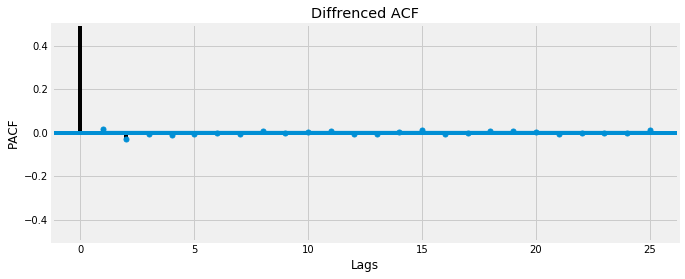

In [98]:
fig, ax = plt.subplots(figsize=(10,4))

plot_acf(data.logsp500, lags = 25, ax = ax)
ax.set_title('Log ACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(10,4))

plot_acf(data.diflogsp500, lags = 25, ax = ax)
ax.set_title('Diffrenced ACF')
ax.set_ylim(-.5, .5)
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

In [158]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data.diflogsp500, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -29.758185
p-value                            0.000000
# Lags Used                       45.000000
Number of Observations Used    41119.000000
Critical Value (1%)               -3.430509
Critical Value (5%)               -2.861610
Critical Value (10%)              -2.566807
dtype: float64


In [182]:
ararray = (data.logsp500.dropna().as_matrix())

p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
                        
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print ("Best Model is :", (p,d,q))
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

C:\Users\q4719\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\q4719\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\q4719\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

(0, 1, 0) -574734.7967624674
(0, 1, 1) -574743.127251369
(0, 1, 2) -574781.3418318452
(1, 1, 0) -574742.5228748941
(1, 1, 1) -574748.4275254577
(1, 1, 2) -574784.7756416036
(2, 1, 0) -574780.8855670723
(2, 1, 1) -574783.0299853915


C:\Users\q4719\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 2) -574758.5416111341
Best Model is : (1, 1, 2)


In [188]:
ARIMIAmod

In [189]:
ARIMIAmod.predict(typ='levels').shape

(41163,)

In [190]:
data.shape

(41164, 5)

In [191]:
data.loc[1:, 'predict'] = ARIMIAmod.predict(typ='levels')

In [192]:
data.head()

,DATE,DATE_F,SP500,logsp500,diflogsp500,predict
0,1491226200,2017-04-03 19:00:00,2363.6101,7.767945,-0.000207,NaN
1,1491226260,2017-04-03 19:01:00,2364.1001,7.768153,0.000601,7.767946
2,1491226320,2017-04-03 19:02:00,2362.6799,7.767552,-0.000690,7.768157
3,1491226380,2017-04-03 19:03:00,2364.3101,7.768242,-0.000228,7.767537
4,1491226440,2017-04-03 19:04:00,2364.8501,7.768470,-0.000326,7.768271


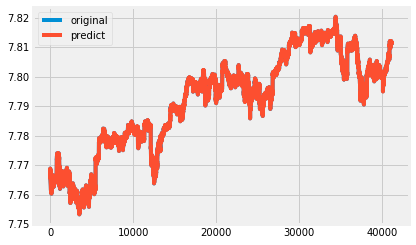

In [193]:
plt.plot(data['logsp500'][1:], label='original')
plt.plot(data.predict[1:], label='predict')
plt.legend()

In [200]:
np.mean(np.abs(np.array((data['logsp500'][1:] - data['predict'][1:]))))

0.0001271085870651819

In [195]:
numofsteps = 10
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors

array([[7.81114721, 7.81202791],
       [7.81096183, 7.81221681],
       [7.81082833, 7.8123528 ],
       [7.81071706, 7.81246629],
       [7.81061909, 7.8125664 ],
       [7.8105304 , 7.8126572 ],
       [7.81044875, 7.81274097],
       [7.81037268, 7.81281915],
       [7.8103012 , 7.81289274],
       [7.81023357, 7.81296248]])

In [196]:
stepahead

array([7.81158756, 7.81158932, 7.81159057, 7.81159167, 7.81159274,
       7.8115938 , 7.81159486, 7.81159591, 7.81159697, 7.81159803])

In [203]:
data['error'] = (data['logsp500'] - data['predict'])
data['sqrError'] = np.square(data['error'])
data['absError'] = np.abs(data['error'])

In [204]:
data.head()

,DATE,DATE_F,SP500,logsp500,diflogsp500,predict,error,sqrError,absError
0,1491226200,2017-04-03 19:00:00,2363.6101,7.767945,-0.000207,NaN,NaN,NaN,NaN
1,1491226260,2017-04-03 19:01:00,2364.1001,7.768153,0.000601,7.767946,0.000206,4.253205e-08,0.000206
2,1491226320,2017-04-03 19:02:00,2362.6799,7.767552,-0.000690,7.768157,-0.000605,3.660954e-07,0.000605
3,1491226380,2017-04-03 19:03:00,2364.3101,7.768242,-0.000228,7.767537,0.000705,4.966409e-07,0.000705
4,1491226440,2017-04-03 19:04:00,2364.8501,7.768470,-0.000326,7.768271,0.000199,3.954212e-08,0.000199


Text(0.5,0,'Month')

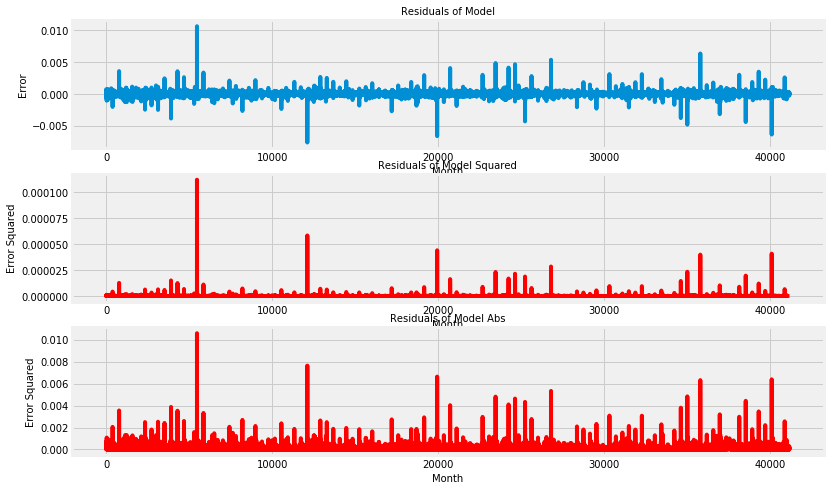

In [207]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(3, 1, 1)
plt.plot(data.error, label = "Residual")
plt.title("Residuals of Model", size = 10,)
plt.ylabel("Error", size = 10)
plt.xlabel('Month', size = 10)

plt.subplot(3, 1, 2)
plt.plot(data.sqrError, label = 'Residual Squared', color = 'r')
plt.title("Residuals of Model Squared", size = 10,)
plt.ylabel("Error Squared", size = 10)
plt.xlabel('Month', size = 10)

plt.subplot(3, 1, 3)
plt.plot(data.absError, label = 'Residual Squared', color = 'r')
plt.title("Residuals of Model Abs", size = 10,)
plt.ylabel("Error Squared", size = 10)
plt.xlabel('Month', size = 10)


Text(0,0.5,'ACF')

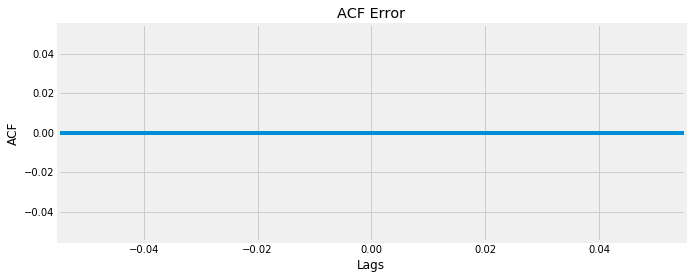

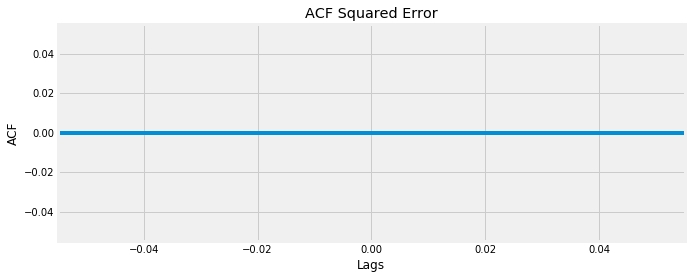

In [113]:
fig, ax = plt.subplots(figsize=(10,4))

plot_acf(data.error, lags = 25, ax = ax)
ax.set_title('ACF Error')
ax.set_xlabel('Lags')
ax.set_ylabel('ACF')

fig, ax = plt.subplots(figsize=(10,4))

plot_acf(data.sqrError, lags = 25, ax = ax)
ax.set_title('ACF Squared Error')
ax.set_xlabel('Lags')
ax.set_ylabel('ACF')

Text(0,0.5,'PACF')

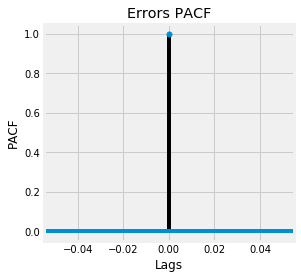

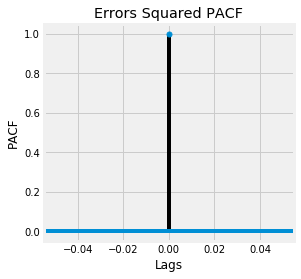

In [208]:
fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(data.error, lags = 25, ax = ax)
ax.set_title('Errors PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

fig, ax = plt.subplots(figsize=(4,4))

plot_pacf(data.sqrError, lags = 25, ax = ax)
ax.set_title('Errors Squared PACF')
ax.set_xlabel('Lags')
ax.set_ylabel('PACF')

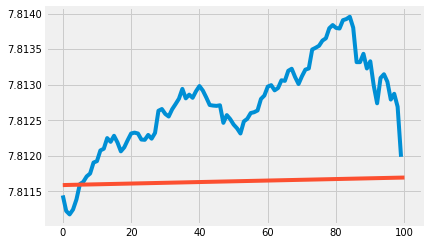

In [209]:
plt.plot(test.reset_index().logsp500)
plt.plot(ARIMIAmod.predict(start=data.shape[0], end=data.shape[0]+100, typ='levels'))

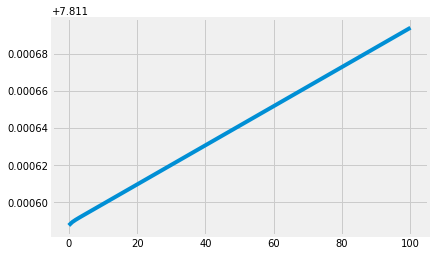

In [210]:
plt.plot(ARIMIAmod.predict(start=data.shape[0], end=data.shape[0]+100, typ='levels'))

In [211]:
test = test.reset_index()

In [ ]:
?ARIMIAmod.forecast

In [127]:
ARIMIAmod.forecast(1)[0]

array([7.81144245])

In [128]:
ararray = list(data.logsp500.values)
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

C:\Users\q4719\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [129]:
test_logsp500 = list(test.logsp500.values)

In [ ]:
ararray = list(data.logsp500.values)
test_predict = []
for i in range(99):
    print(i)
    ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()
    test_predict.append(ARIMIAmod.forecast(1)[0])
    ararray.append(test_logsp500[i])

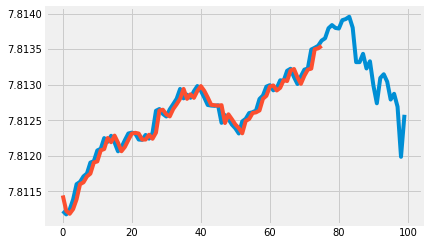

In [139]:
plt.plot(test_logsp500)
plt.plot(np.array(test_predict).ravel())

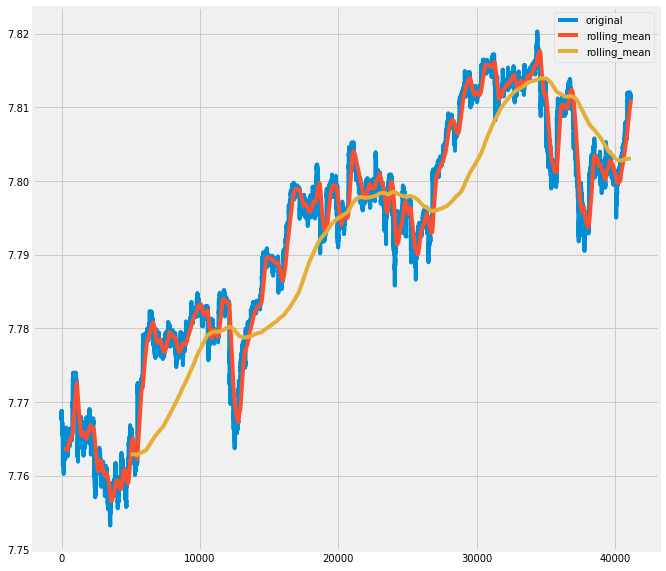

In [226]:
plt.figure(figsize=(10,10))
plt.plot(data.logsp500, label='original')
plt.plot(data.logsp500.rolling(300).mean(), label='rolling_mean')
plt.plot(data.logsp500.rolling(5000).mean(), label='rolling_mean')
plt.legend()

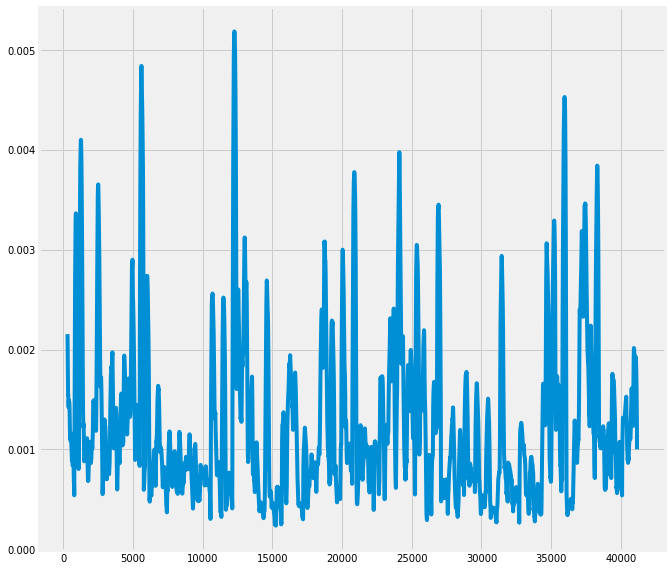

In [224]:
plt.figure(figsize=(10,10))
plt.plot(data.logsp500.rolling(300).std())